In [19]:
import os
import json
import librosa
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F

# for my transformations
#import librosa
from audiomentations import Compose, AddGaussianNoise, PitchShift, TimeStretch, ClippingDistortion, Gain, SevenBandParametricEQ


def resize_mel_spectrogram(mel_spec, desired_shape=(224, 224)):
    # Convert the 2D Mel spectrogram to 4D tensor (batch, channels, height, width)
    mel_spec_tensor = torch.tensor(mel_spec).unsqueeze(0).unsqueeze(0)
    # Resize
    resized_mel_spec = F.interpolate(mel_spec_tensor, size=desired_shape, mode='bilinear', align_corners=False)
    return resized_mel_spec.squeeze(0).squeeze(0).numpy()

# augmentation
augment_raw_audio = Compose(
    [
        AddGaussianNoise(min_amplitude=0.0001, max_amplitude=0.0005, p=1), # good
        PitchShift(min_semitones=-2, max_semitones=12, p=0.5), #set values so it doesnt shift too low, rmeoving bomb signal
        TimeStretch(p = 0.5), # defaults are fine
        ClippingDistortion(0, 5, p = 0.5), # tested params to make sure its good
        Gain(-10, 5, p = 0.5), # defaults are fine
        # throws an error, so i commented it out
        #SevenBandParametricEQ(-12, 12, p = 0.5)
    ]
)

# Modify the load_audio_and_get_mel_spectrogram function:
def mel_spectrogram_func(filename, augment, sr=8000, n_mels=128, n_fft=1024, hop_length=64, win_length=512):
    y, _ = librosa.load(filename, sr=sr)

    # apply transformations for train data if True, not for test data if False
    if augment ==True:
        # pass to augmentation function first then pass to mel spec below
        audio_signal = augment_raw_audio(y, sr)
    else:
        # skip right to mel spec below
        audio_signal = y

    # compute the Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_signal, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    mel_spectrogram_resized = resize_mel_spectrogram(mel_spectrogram)
    return mel_spectrogram_resized



class CTDataset(Dataset):

    def __init__(self, cfg, split, transform):
        '''
            Constructor. Here, we collect and index the dataset inputs and labels.
        '''
        #if split == 'unlabeled':
         #   print('This will not work unless you change the getitem function to have no labels for the unlabeled set') 
        self.data_root = cfg['data_path']
        self.split = split
        self.transform = transform
#

        # index data from JSON file
        self.data = []
        with open(cfg['json_path'], 'r') as f:
            json_data = json.load(f)
            for sublist in json_data.values():
                for entry in sublist:
                    #print(entry)

                    if entry["data_type"] == split:
                        path = entry["file_name"]
                        label = entry["class"]
                        self.data.append([path, label]) ###chNGED TO LIST 

    def __len__(self):
        '''
            Returns the length of the dataset.
        '''
        return len(self.data)

    def __getitem__(self, idx):
        '''
            Returns a single data point at given idx.
            Here's where we actually load the audio and get the Mel spectrogram.
        '''
        #print(f'shape of id: {type(idx)}')
        #print(idx)
        audio_path, label = self.data[idx]

        # load audio and get Mel spectrogram
        if self.transform == True:
            mel_spectrogram = mel_spectrogram_func(filename = os.path.join(self.data_root, audio_path), augment = True)
        elif self.transform == False:
            mel_spectrogram = mel_spectrogram_func(filename = os.path.join(self.data_root, audio_path), augment = False)

        else:
            raise ValueError("The 'transform' parameter must be either True or False.")

            
        
        # make 3 dimensions, so shape goes from [x, y] to [3, x, y]
        mel_spectrogram_tensor = torch.tensor(mel_spectrogram).unsqueeze(0).repeat(3, 1, 1).float()
        
        return mel_spectrogram_tensor

In [20]:
# Sample config for demonstration
cfg_sample = {
    'data_path': '/mnt/ssd-cluster/ben/data/full_dataset/', 
    'json_path': '/home/ben/reef-audio-representation-learning/data/dataset.json'
}

# Let's see if the class is structured correctly:
audio_dataset = CTDataset(cfg_sample, 'train_data', transform=True)

In [18]:
len(audio_dataset)

54457

In [21]:
audio_dataset[0].shape

<class 'NoneType'>


tensor([[[1.3660e-01, 2.1789e-01, 2.3932e-01,  ..., 2.4198e-01,
          2.1977e-01, 1.3747e-01],
         [9.9884e-02, 1.4915e-01, 1.5762e-01,  ..., 1.5939e-01,
          1.5049e-01, 1.0061e-01],
         [4.1146e-02, 3.9155e-02, 2.6901e-02,  ..., 2.7230e-02,
          3.9648e-02, 4.1634e-02],
         ...,
         [7.4634e-07, 8.3082e-07, 9.9777e-07,  ..., 3.3037e-06,
          6.6406e-06, 8.2426e-06],
         [5.7972e-07, 7.2548e-07, 8.2264e-07,  ..., 2.2194e-06,
          4.2058e-06, 5.4516e-06],
         [4.7558e-07, 6.5964e-07, 7.1318e-07,  ..., 1.5417e-06,
          2.6840e-06, 3.7073e-06]],

        [[1.3660e-01, 2.1789e-01, 2.3932e-01,  ..., 2.4198e-01,
          2.1977e-01, 1.3747e-01],
         [9.9884e-02, 1.4915e-01, 1.5762e-01,  ..., 1.5939e-01,
          1.5049e-01, 1.0061e-01],
         [4.1146e-02, 3.9155e-02, 2.6901e-02,  ..., 2.7230e-02,
          3.9648e-02, 4.1634e-02],
         ...,
         [7.4634e-07, 8.3082e-07, 9.9777e-07,  ..., 3.3037e-06,
          6.640

In [55]:
type(audio_dataset[0])

torch.Tensor

### Plot a raw audio files
First plot a melspec of a raw audio file. Next we will plot a melspec from the tensor from an audio_dataset object. They should look similar in quality (though the audio_dataset obj will be augmented).


In [7]:
import matplotlib.pyplot as plt
import os 

/mnt/ssd-cluster/ben/data/full_dataset/train_data.convmet.004464.florida_keys.bioph_fish.wav


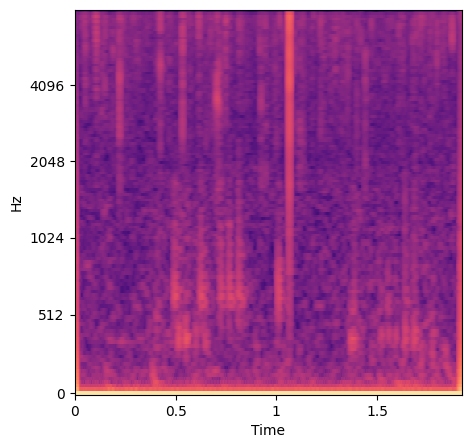

In [11]:
# pick a file from full_dataset
num = 5000
hop_length = 64
sample_rate = 16000

# find all train files in full_dataset
files = os.listdir(cfg_sample['data_path'])
train_files = [f for f in files if f.startswith('train_data')]

# get the files full path
audio_file_path = cfg_sample['data_path'] + train_files[num]
print(audio_file_path)
    
# load an audio file
audio, sample_rate = librosa.load(audio_file_path, sr = sample_rate)

# compute the mel spectrogram of the audio
mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=128, n_fft=2048, hop_length=64, win_length=1024)

# convert the power spectrogram to decibel (dB) units 
mel_spec_db = librosa.power_to_db(S=mel_spec, ref=1.0) 

#### plot the spectrogram
plt.figure(figsize=(5, 5))
librosa.display.specshow(mel_spec_db, sr=sample_rate,  
                        y_axis='mel', x_axis='time',  
                        vmin = -100, vmax = 0, 
                        cmap = 'magma', hop_length=hop_length)

Now the the mel_spectrogram_np tensor plot

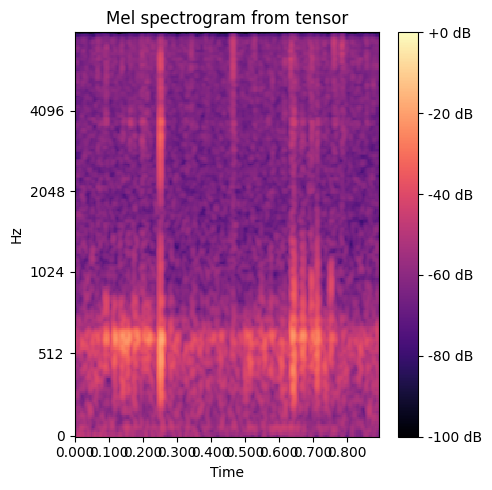

In [15]:
# Get the Mel spectrogram tensor for a dataset item (e.g., the first item)
mel_spectrogram_tensor = audio_dataset[10]

# Convert the tensor back to numpy for visualization and apply dB scaling
mel_spectrogram_np = mel_spectrogram_tensor.numpy()[0]  # Selecting one channel for visualization
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram_np, ref=1.0)

# Plot the Mel spectrogram using the settings you provided
plt.figure(figsize=(5, 5))
librosa.display.specshow(mel_spectrogram_db, sr=sample_rate, 
                         n_fft=2048, hop_length=64, win_length=1024,
                         y_axis='mel', x_axis='time',
                         vmin=-100, vmax=0,
                         cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram from tensor')
plt.tight_layout()
plt.show()